## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


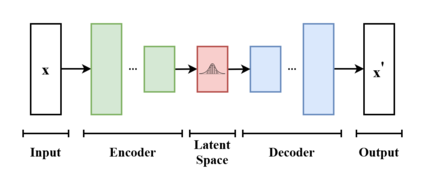

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

### Error 1
current code
```import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm


# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2




# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

```





error
```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/tmp/ipython-input-3016409084.py in <cell line: 0>()
      2 reconstruction_loss = losses.binary_crossentropy(inputs_flat,
      3                                                  outputs_flat) * x_tr_flat.shape[1]
----> 4 kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
      5 vae_flat_loss = reconstruction_loss + kl_loss
      6

6 frames
/usr/local/lib/python3.12/dist-packages/keras/src/backend/common/keras_tensor.py in __tf_tensor__(self, dtype, name)
    154
    155     def __tf_tensor__(self, dtype=None, name=None):
--> 156         raise ValueError(
    157             "A KerasTensor cannot be used as input to a TensorFlow function. "
    158             "A KerasTensor is a symbolic placeholder for a shape and dtype, "

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```

```

K.square, K.exp, K.sum, etc. are TensorFlow ops, not Keras ops.
When you write:
Python
```
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis=-1)
```
Keras sees the symbolic tensor mu_flat being passed to a TF function and raises the guard-error you got.
The quick fix: use the Keras-3 / TF2.x math namespace that is allowed inside a Functional model, i.e. keras.ops (or the convenience alias keras.ops.numpy).

### Error 2
```
---------------------------------------------------------------------------
NotImplementedError                       Traceback (most recent call last)
/tmp/ipython-input-2042874171.py in <cell line: 0>()
     13 #  Ensure that the reconstructed outputs are as close to the inputs
     14 vae_flat = Model(inputs_flat, outputs_flat)
---> 15 vae_flat.add_loss(vae_flat_loss)
     16 vae_flat.compile(optimizer='adam')

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py in add_loss(self, loss)
    344     def add_loss(self, loss):
    345         # Symbolic only. TODO
--> 346         raise NotImplementedError
    347
    348     @property

NotImplementedError:
```
In Keras 3 the Functional API model no longer accepts
model.add_loss(some_tensor).
The intended way is to pass the loss inside a custom-training step
or – much simpler – wrap the extra loss in a Layer and let the
model compute it automatically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf # added
import tensorflow.keras as keras # added
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Layer # added Layer
from tensorflow.keras.models import Model
from tensorflow.keras import ops          # <── new import
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [4]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [5]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

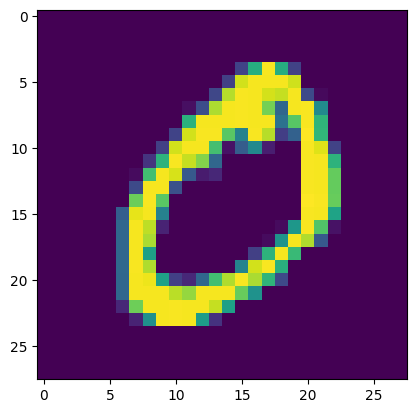

In [6]:
# Example of a training image
plt.imshow(x_tr[1]);

In [7]:
# sampling function
def sampling(args):
    mu, log_var = args

    # keras.ops does not expose random_normal; the Keras-3 random API is
    # keras.random.normal.
    # Replace the line and do not hard-code the batch dimension – use the
    # actual batch size at run-time
    # eps = ops.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    # dynamic batch size
    batch = ops.shape(mu)[0]
    eps = keras.random.normal(shape=(batch, z_dim), mean=0.0, stddev=1.0)

    return mu + ops.exp(log_var) * eps

In [8]:
# # Encoder - from 784->256->128->2
# inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
# x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
# x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# # hidden state, which we will pass into the Model to get the Encoder.
# mu_flat = Dense(z_dim)(x_flat)
# log_var_flat = Dense(z_dim)(x_flat)
# z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [9]:
# #Decoder - from 2->128->256->784
# latent_inputs = Input(shape=(z_dim,))
# z_decoder1 = Dense(n_hidden//2, activation='relu')
# z_decoder2 = Dense(n_hidden, activation='relu')
# y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
# z_decoded = z_decoder1(latent_inputs)
# z_decoded = z_decoder2(z_decoded)
# y_decoded = y_decoder(z_decoded)
# decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

# outputs_flat = decoder_flat(z_flat)

In [10]:
# # variational autoencoder (VAE) - to reconstruction input
# reconstruction_loss = losses.binary_crossentropy(inputs_flat,
#                                                  outputs_flat) * x_tr_flat.shape[1]
# # reconstruction_loss = losses.binary_crossentropy(inputs_flat, outputs_flat)
# # reconstruction_loss *= 784          # scale by input dimension

# kl_loss = -0.5 * ops.sum(1 + log_var_flat
#                            - ops.square(mu_flat)
#                            - ops.exp(log_var_flat), axis=-1)
# vae_flat_loss = reconstruction_loss + kl_loss

# # Build model
# #  Ensure that the reconstructed outputs are as close to the inputs
# vae_flat = Model(inputs_flat, outputs_flat)
# vae_flat.add_loss(vae_flat_loss)
# vae_flat.compile(optimizer='adam')

In [11]:
# # train
# vae_flat.fit(
#     x_tr_flat,
#     shuffle=True,
#     epochs=n_epoch,
#     batch_size=batch_size,
#     validation_data=(x_te_flat, None),
#     verbose=1
# )

In [45]:
# 2.  KL-scheduling parameters
# KL Divergence Weighting (Beta): The beta variable in your VAE class's compute_loss function controls the weight of the KL divergence term. If beta is too high initially, the model is heavily penalized for deviating from the prior distribution, forcing the embeddings into a compact, less discriminative space
# beta_init  = 6.0 # 10.0
beta_init  = 0.5          # start with a strong KL push
capacity   = 1.0          # free-bits / capacity (will be annealed)
beta       = tf.Variable(beta_init, trainable=False, dtype=tf.float32)
capacity_t = tf.Variable(capacity,  trainable=False, dtype=tf.float32)



class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        mu, log_var, z = self.encoder(inputs)
        return self.decoder(z), mu, log_var

    def compute_loss(self, x):
        x_rec, mu, log_var = self(x)
        # rec = reconstruction loss
        rec = tf.reduce_mean(losses.binary_crossentropy(x, x_rec)) * 784

        # kl = kl divergence
        # round1 - points from different classes not well-separated
        # kl  = -0.5 * ops.mean(
        #           ops.sum(1 + log_var
        #                   - ops.square(mu)
        #                   - ops.exp(log_var), axis=-1))

        # round2
        # in compute_loss
        kl = -0.5 * ops.sum(1 + log_var
                            - ops.square(mu)
                            - ops.exp(log_var), axis=-1)
        kl = ops.maximum(kl - capacity_t, 0.0)   # free-bits
        kl = ops.mean(kl)

        # round3
        kl_raw = -0.5 * (1 + log_var - ops.square(mu) - ops.exp(log_var))   # (B,z_dim)
        # kl_per_dim = ops.maximum(kl_raw - 2.0, 0.0)                         # free-bits
        # kl = ops.mean(ops.sum(kl_per_dim, axis=1))
        kl = kl_raw
        loss = rec + beta * kl

        # round 2
        # return rec + beta * kl
        # round 3
        return loss

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {'loss': loss}

    def test_step(self, data):
        x = data
        loss = self.compute_loss(x)
        return {'loss': loss}

# ------------------------------------------------------------------
# build encoder / decoder as ordinary Functional models
# Encoder - from 784->256->128->2
enc_in = Input(shape=(784,))
x = Dense(n_hidden, activation='relu')(enc_in) # hidden layer 1
x = Dense(n_hidden//2, activation='relu')(x) # hidden layer 2
mu      = Dense(z_dim)(x)
log_var = Dense(z_dim)(x)
# Lambda layer cannot guess the shape that sampling returns, so Keras 3 forces you to declare it explicitly.
# Give Lambda the argument output_shape=(z_dim,) (or let it be inferred with a tiny wrapper layer) and the error disappears.
# z = Lambda(sampling)([mu, log_var])
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
encoder = Model(enc_in, [mu, log_var, z], name='encoder')


#Decoder - from 2->128->256->784
dec_in = Input(shape=(z_dim,))
y = Dense(n_hidden//2, activation='relu')(dec_in) # hidden 2
y = Dense(n_hidden, activation='relu')(y) # hidden 1
y = Dense(784, activation='sigmoid')(y) # sigmoid classification
decoder = Model(dec_in, y, name='decoder')

# ------------------------------------------------------------------
# 6.  instantiate & compile
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# ------------------------------------------------------------------
# 7.  simple β-annealing callback
class BetaSchedule(tf.keras.callbacks.Callback):
    def __init__(self, beta_final=1.0, n_epochs=n_epoch):
        super().__init__()
        self.beta_final = beta_final
        self.n_epochs   = n_epochs
    def on_epoch_begin(self, epoch, logs=None):
        new_beta = beta_init * max(0.0, 1.0 - epoch / (0.3 * self.n_epochs))
        beta.assign(max(new_beta, self.beta_final))

# ------------------------------------------------------------------
# 8.  train
vae.fit(x_tr_flat, None,
        epochs=n_epoch,
        batch_size=batch_size,
        validation_data=(x_te_flat, None),
        callbacks=[BetaSchedule()])

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 191.7216 - val_loss: 0.0000e+00
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 161.0352 - val_loss: 0.0000e+00
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 155.2965 - val_loss: 0.0000e+00
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 152.1958 - val_loss: 0.0000e+00
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 149.9118 - val_loss: 0.0000e+00
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 147.8074 - val_loss: 0.0000e+00
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 146.1716 - val_loss: 0.0000e+00
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 144.8031 - val_loss: 0.0000e+00
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 143.6313 - val_loss: 0.0000e+00
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.7827 - val_loss: 0.0000e+00
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - lo

### Visualize Embeddings

In [46]:
from tensorflow.keras import layers

# ---------- recreate the input and encoder path ----------
inputs_flat = layers.Input(shape=(784,))          # 784-dim MNIST vectors
x = layers.Dense(n_hidden, activation='relu')(inputs_flat)
x = layers.Dense(n_hidden//2, activation='relu')(x)
mu_flat      = layers.Dense(z_dim)(x)
log_var_flat = layers.Dense(z_dim)(x)
z_flat = layers.Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

# ---------- now build the encoder model ----------
encoder_f = Model(inputs_flat, z_flat, name='encoder_f')

In [14]:
# # Build encoders
# # encoder_f = Model(inputs_flat, z_flat)  # flat encoder
# encoder_f = Model(inputs_flat, [z_flat, mu_flat, log_var_flat])

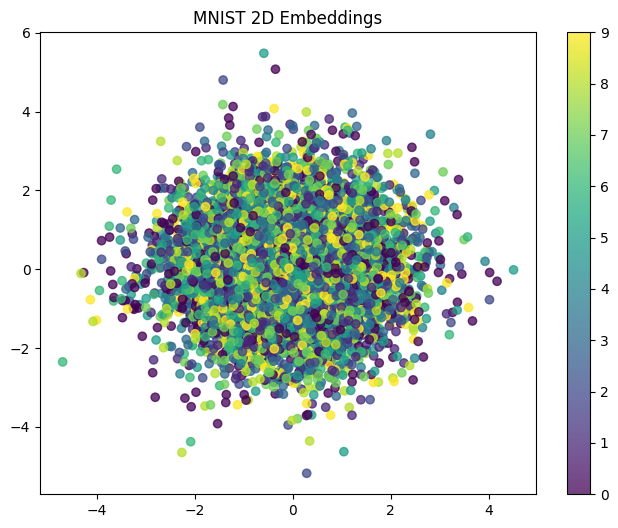

In [47]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

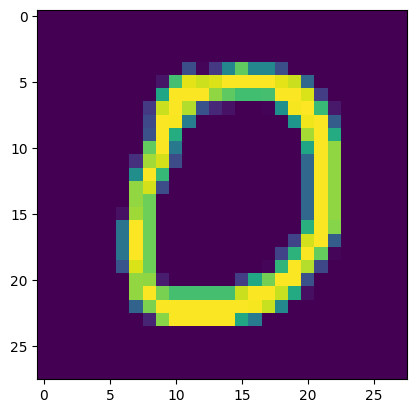

In [16]:
plt.imshow(x_te_flat[10].reshape(28,28));

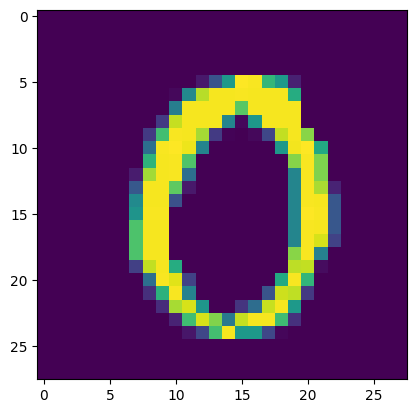

In [17]:
plt.imshow(x_te_flat[13].reshape(28,28));

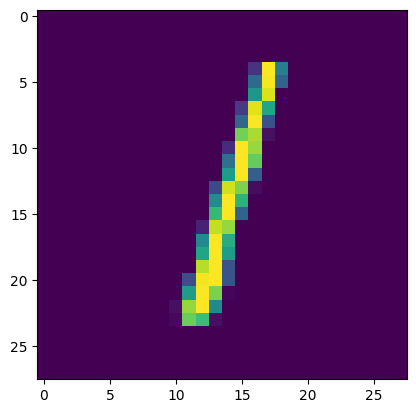

In [18]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [19]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [-0.32721585 -1.2865342 ]
Embedding for the second ZERO is [-0.66566736 -0.16372252]
Embedding for the ONE is         [0.22489497 0.17941163]


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [20]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [21]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [22]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061977  0.26414245  0.21265678 ...  0.14994559 -0.2579491
  -0.23970762]
 [ 0.6693327   0.40094954 -0.48208416 ...  0.10645907 -1.5067159
  -0.01547337]
 [-0.26555938  0.11172415 -0.14733033 ...  0.4219748   0.88394576
   0.10763928]]


In [23]:
embedding.shape

(3, 384)

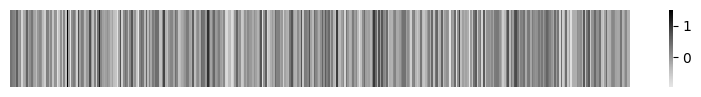

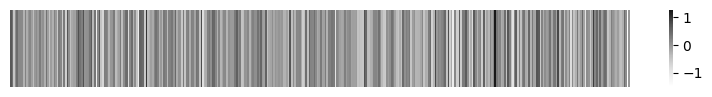

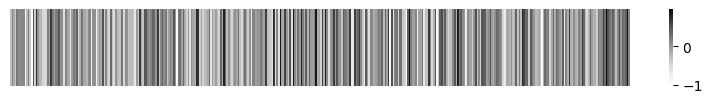

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

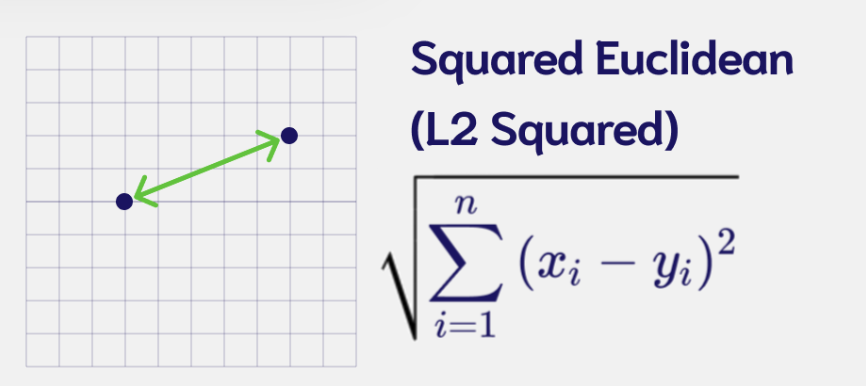

In [25]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

1.1727129


In [26]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

np.float32(1.1727129)

In [27]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 1.1727129
Distance zeroA-one:   1.5664685
Distance zeroB-one:   0.9543806


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

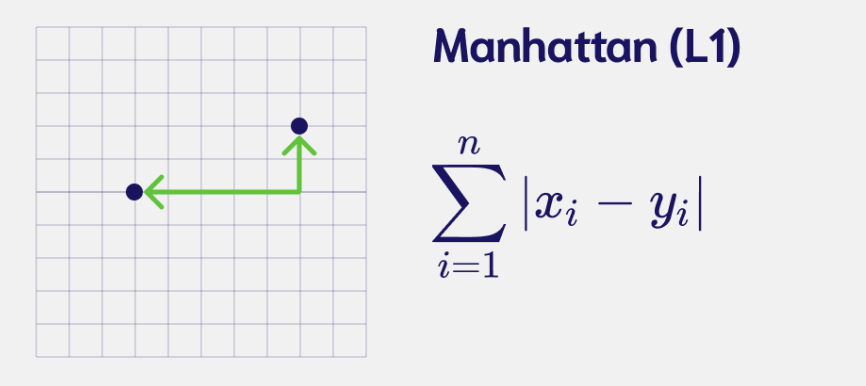

In [28]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

1.4612632


In [29]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

np.float32(1.4612632)

In [30]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 1.4612632
Distance zeroA-one:   2.0180566
Distance zeroB-one:   1.2336965


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

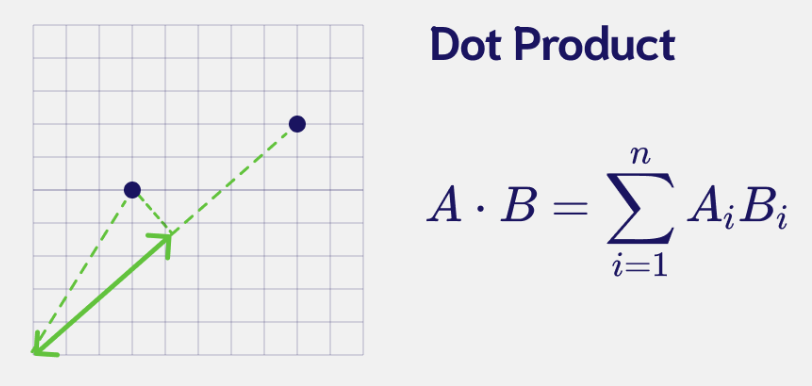

In [31]:
# Dot Product
np.dot(zero_A,zero_B)

np.float32(0.42845154)

In [32]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 0.42845154
Distance zeroA-one:   -0.3044084
Distance zeroB-one:   -0.17907897


### Cosine Distance
Measure the difference in directionality between vectors.

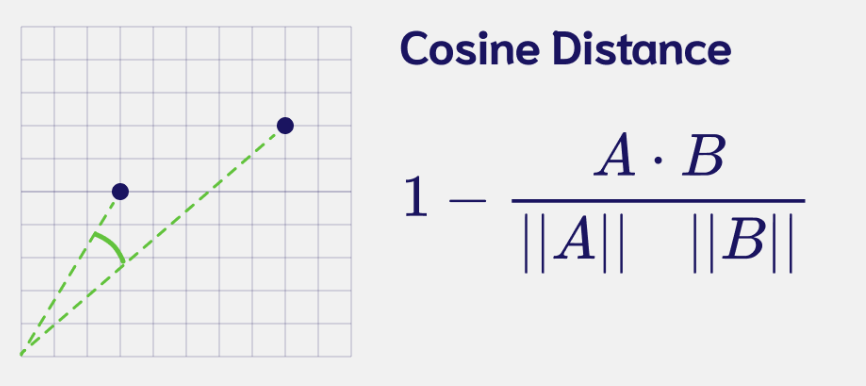

In [33]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.529177


In [34]:
zero_A/zero_B

array([0.4915606, 7.8580165], dtype=float32)

In [35]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [36]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.529177
Distance zeroA-one:    1.797072
Distance zeroB-one:    1.908044


## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [37]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.078577
Distance 1-2: 4.0192127


In [38]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350336
Distance 0-2:  0.9639393
Distance 1-2:  0.9288791
